In [1]:
#!conda create -n perturbseq_pipeline python=3.8
#activate this env


## TODO
- [X]  checkedRUN AGAIN WITH A MODIFIED EXCEL (CHANGING THE NAME OF THE NEGATIVE CONTROL GENES)
- [X] Eliminate guides present with less than 30 cells
- [X] Fix the single batch problem 
- [X]  SOLVE THE PROBLEM TO RUN AGAINST ALL GENES (TRANS ANALYSIS) (Should be configured by guide in the future?)
- [ ]  ADD PARAMETERS TO SOME OF THE FUNCTIONS (THEY ARE HARDCODED NOW ..EX: merge..number of cells and etc)
- [ ]  Create a nice description to the input files
- [ ]  fix the Rbase version to 4.2.2
- [ ]  change threads to cpus  (taks.cpu)
- [ ]  probably I can provide a list of elements and ask nextflow to handle the paralelizing (receiving the elements names in a channel?)
- [ ]  Create easing options to add 3'and 5'chemistry
- [ ]  how is the -report flag in the count comand? is this memory expensive?
- [ ]  Cell hashing and Multi-seq ? https://www.ncbi.nlm.nih.gov/sra?linkname=bioproject_sra_all&from_uid=719672

In [28]:
# !pip uninstall GTFProcessing -y
# !pip install git+https://github.com/LucasSilvaFerreira/GTFProcessing.git
#!pip install gtfparse==1.3.0

  Cloning https://github.com/LucasSilvaFerreira/GTFProcessing.git to /tmp/pip-req-build-qasixy7x
  Running command git clone --filter=blob:none --quiet https://github.com/LucasSilvaFerreira/GTFProcessing.git /tmp/pip-req-build-qasixy7x
  Resolved https://github.com/LucasSilvaFerreira/GTFProcessing.git to commit 05c648c23f573db3ab8f5f78b799d0e19ad01cee
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 60.7 MB/s eta 0:00:0000:0100:01
  Created wheel for GTFProcessing: filename=GTFProcessing-0.0.1-py3-none-any.whl size=2690 sha256=34adfb3a2d1865f6f12a08ef1b2c260442d1ef6ec2ac0d33c60deb01f33cc101
  Stored in directory: /tmp/pip-ephem-wheel-cache-z9etx6os/wheels/53/4a/9b/d0e3b507252cebe65a063ed1d0cbb9045bc374be7b25a3467e
  Created wheel for gtfparse: filename=gtfparse-2.0.1-py3-none-any.whl size=15284 sha256=f247633578eec0f8f7be5a19cfc270f550c5048cb4ef651a0e25aca64ab0f148
  Stored in directory: /home/l

In [30]:
#!pip install git+https://github.com/LucasSilvaFerreira/Perturb_Loader.git

In [2]:
# !mamba install -c bioconda nextflow -y
# !mamba install -c bioconda kallisto -y
# pip install --quiet kb-python
#!mamba install -c anaconda openpyxl -y 

In [ ]:
# !mamba install -c conda-forge r-base -y 
# #the final r shoudl be 4.2.2 FIX IT

# !Rscript -e 'install.packages("BiocManager", repos = "http://cran.us.r-project.org")'
# !Rscript -e 'BiocManager::install("Rhdf5lib")'
# !Rscript -e 'BiocManager::install("rhdf5")'
# !Rscript -e 'install.packages("doParallel", repos = "http://cran.us.r-project.org")'
# !Rscript -e 'install.packages("devtools", repos = "http://cran.us.r-project.org")'
# !mamba install -c conda-forge r-gert -y 
# !mamba install -c conda-forge r-ragg -y
# !Rscript -e 'install.packages("devtools", repos = "http://cran.us.r-project.org")'
# !mamba install -c conda-forge r-ggplot2
# !Rscript -e 'devtools::install_github("katsevich-lab/sceptre")'


In [ ]:
#!mamba install -c bioconda fastqc -y

# IMPORTANT CONCEPTS
- always pass all the __NON__ list parameters using collect() when 'executing' the same comand for different files. (all chanels should have the same size case looping)
- Use the flag -w when calling the pipeline or the works will save just the last executed 
- script'''  whith single    ''' doesnt work use  script """ with double """ 
- use chache 'lenient' when the timestapm (not determinist) process?
- make sure you need to channel your path outputs (sometimes it is already in the correct format)  
- use a combination of join,remainder=true and flatten to list to have paths inside a same input  
ex:  dir_count_files = map_guide.ks_guide_out.join(map_rna.ks_transcripts_out, remainder: true).flatten().toList()
- Case creating tables that referece files , MAKE SURE pass the same variable used to generate the table to the function receiving the files.



# PARAMETERS ()


notes:   
TRANSCRIPTOME_REFERENCE = 'human'   #mouse   #add options to custom genomes in the next versions. Lets be transparent about the genome versions in the future  
KALLISTO_BIN = '/home/lf114/miniconda3/envs/perturbseq_pipeline/bin/kallisto'  # How to capture this which? How about the multiple versions? should we compiple using kl compile  
GUIDE_FEATURES = tabular file with guide name (non-duplicated guide names) and sequence (no header)  


In [30]:
import pandas as pd

df_features = pd.read_excel('5p27sgRNA_guide_metainfo_modified.xlsx')
#MAKESURE TO ADD | TO GUIDES TARGETING THE SAME REGION AND A NUMBER
# df_features[[ 'sgRNA_sequences', 'sgRNA_name']].to_csv('genome_features.txt', sep='\t', header=None, index=None)

In [1]:
!pwd

/n/scratch3/users/l/lf114/pipeline_perturbseq_like


In [9]:
%%writefile /n/scratch3/users/l/lf114/pipeline_perturbseq_like/bin/fq_composition.py
#!/usr/bin/env python

#Read composition discover
import pandas as pd
import matplotlib.pyplot as plt
import os

def get_reads_fasta(fasta):
    check_guides = f"zcat '{fasta}' | head -n 10000 "
    print (check_guides)
    seqs =  os.system(check_guides) #!$check_guides 
    #print (seqs)
    return [ x for x in seqs if '@' not in x and '+' not in x and 'F'not in x]
    
def compositional_bias_calculation(fasta_df, name, dir_out) :  
    plt.rcParams["figure.figsize"] = (25,2)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

    df_calculate_percentages = pd.DataFrame([  [ a for a in s[:]] for s in fasta_df ])
    (pd.concat([ (df_calculate_percentages == nucleotide).sum()  for nucleotide in ['A', 'C', 'T', 'G']], axis=1).T - df_calculate_percentages.shape[0] ).std().plot()
    plt.xlim(0,df_calculate_percentages.shape[1])
    plt.xticks(rotation=90)
    plt.title(f'{name}:: + Compositional Bias \n (sd between the 4 nucleotides) ')
    plt.savefig(f'{dir_out}_composition/{name}_composition.png')
    plt.clf()

    
def plot_compositional_bia(R1,R2, prefix_tag):    
    compositional_bias_calculation(get_reads_fasta(R1), name=f'{prefix_tag}_R1' ,dir_out=prefix_tag)   
    compositional_bias_calculation(get_reads_fasta(R2), name=f'{prefix_tag}_R2', dir_out = prefix_tag )   


read1 = os.argv[1]
read2 = os.argv[2]
prefix_tag = os.argv[3]
plot_compositional_bia(read1,read2,prefix_tag)

Overwriting /n/scratch3/users/l/lf114/pipeline_perturbseq_like/bin/fq_composition.py


25

@A01754:104:H5K5NDSX5:1:1101:1009:1016 2:N:0:GTGGATCAAA+NAGGGTTGGC
CAAGTTGATAACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGCATAGCTCTTAAACGGCCATCTCGCTGCCCGACGCCCCATATAAGAAAACCC
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
@A01754:104:H5K5NDSX5:1:1101:1027:1016 2:N:0:GTGGATCAAA+NAGGGTTGGC
CAAGTTGATACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGCATAGCTCTTAAACCCGAGGGGCAGGGCGGTCCCCCCCATATAAGAAAGCCTG
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
@A01754:104:H5K5NDSX5:1:1101:1208:1016 2:N:0:GTGGATCAAA+NAGGGTTGGC
CAAGTTGATAACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGCATAGCTCTTAAACCCAGCTTTGGACGATCTCAACCCCCATATAAGAAAAAG
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFF:FFFFF:FFFFFFFFF:FFFFFFFFFFFFFFFFFF,F:
@A01754:104:H5K5NDSX5:1:1101:1443:1016 2:N:0:GTGGATCAAA+NAGGGTTGGC
CAAGTTGATAACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGCATAGCTCTTAAACTACATCCTGAGATCATGAGCCCCCATATAAGAAATAGC
+
FFFF:FFF:F

In [7]:

from re import finditer


import numpy as np
conversion = dict(zip('A C T G'.split(' '),'T G A C'.split(' ')))

def get_guide_number_frequent_sequence(curr_seq):
    curr_seq
    check_guides = !zcat '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz' | head -n 100000
    #check_guides = ['CAAGTTGATAACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGC']
    len_seq = len([i for i in check_guides if curr_seq in i])
    match_mean_pos = np.mean([   [f.span() for f in  finditer(curr_seq, i )][0] for i in check_guides if curr_seq in i])

    print (len_seq, match_mean_pos)
    return  len_seq, match_mean_pos

get_guide_number_frequent_sequence('CAAGTTGATAACGGACTAGCCTTATTTAAACTTGCTATGCTGTTTCCAGC')

23698 25.00016879061524


(23698, 25.00016879061524)

In [47]:
df_features
import numpy as np
conversion = dict(zip('A C T G'.split(' '),'T G A C'.split(' ')))
from re import finditer

def get_guide_number(curr_seq):
    curr_seq = ''.join( [conversion[s] for s in curr_seq[::-1]])
    check_guides = !zcat '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz' | head -n 100000
    len_seq = len([i for i in check_guides if curr_seq in i])
    match_mean_pos = np.mean([   [f.span() for f in  finditer(curr_seq, i )][0] for i in check_guides if curr_seq in i])

    print (len_seq, match_mean_pos)
    return  len_seq, match_mean_pos





    

df_features['guide_reads_in_fastq_samples'] = df_features['sgRNA_sequences'].apply(lambda x : get_guide_number(x)[0]  )
#f_features['guide_mean_position_R2'] = df_features['sgRNA_sequences'].apply(lambda x : get_guide_number(x)[1]  )

720 73.24444444444444
1307 73.0053557765876
1425 73.2280701754386
3520 72.86846590909092
2134 72.4601686972821
170 73.0
2138 72.99017773620206
837 72.44205495818399
837 73.44086021505376
838 73.01909307875896
168 73.80952380952381
463 73.170626349892
36 73.02777777777777
204 73.17647058823529
560 73.09642857142858
697 73.00430416068866
852 73.01408450704226
309 73.01294498381877
1369 72.98612125639153
357 73.0
1938 73.63673890608875
75 72.98666666666666
3046 73.04596191726854
103 73.01941747572816
2319 73.00646830530401
17 73.0
38 73.02631578947368


<AxesSubplot: xlabel='sgRNA_ID'>

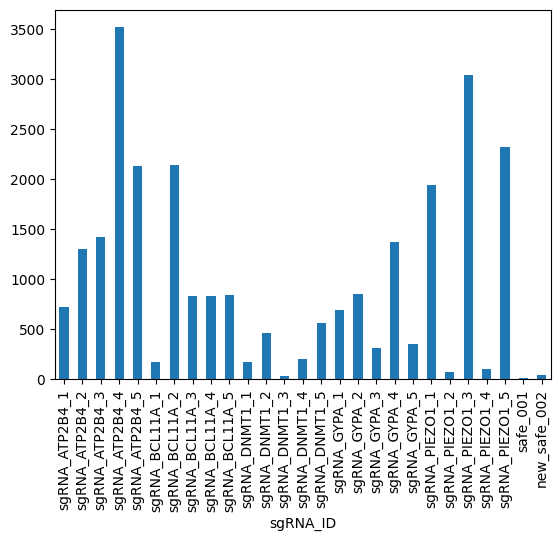

In [53]:
df_features.index = df_features['sgRNA_ID']
df_features['guide_reads_in_fastq_samples'].plot.bar()

In [57]:
!mkdir fqqc_quality_R1
!fastqc -o fqqc_quality_R1 /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz -t 8 


mkdir: cannot create directory ‘fqqc_quality_R1’: File exists
Started analysis of 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 5% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 10% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 15% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 20% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 25% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 30% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 35% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 40% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 45% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 50% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 55% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz
Approx 60% complete

In [59]:
!mkdir fqqc_quality_R2
!fastqc -o fqqc_quality_R2 /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz -t 8 


Started analysis of 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 5% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 10% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 15% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 20% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 25% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 30% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 35% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 40% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 45% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 50% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 55% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Approx 60% complete for 5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz
Appr

In [11]:

len('ATCACCCTTACTTGCATCAGCAAAGGGGTCGAAAGAGTGGAGGTTCTGGATAGCGGACATACGATACGATTCCTTTTCCTCGGTGGAAACGGCCTGCGGAA')


10xv3     
0,0,16:0,16,26:0,26,0,1,0,0    -> sc5'pe
#params.CHEMISTRY = '0,0,16:0,16,26:0,26,0,1,0,0'


101

In [ ]:
#testing different lanes
# params.FASTQ_FILES_TRANSCRIPTS = ['/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz',
#                                   '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz',
#                                  '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz']

# params.FASTQ_NAMES_TRANSCRIPTS = ['S1_L1',
#                                   'S1_L2',
#                                   'S2_L1']


# params.FASTQ_FILES_GUIDES = ['/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz',
#                             '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz' ]

# params.FASTQ_NAMES_GUIDES = ['S1_L1' ,
#                              'S1_L2']



In [1]:

// Declare syntax version
nextflow.enable.dsl=2
// Script parameters
params.GTF_GZ_LINK = 'http://ftp.ensembl.org/pub/release-106/gtf/homo_sapiens/Homo_sapiens.GRCh38.106.gtf.gz'
params.TRANSCRIPTOME_REFERENCE = "human"
params.KALLISTO_BIN = '/home/lf114/miniconda3/envs/perturbseq_pipeline/bin/kallisto'
params.GENOME = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz'
params.GUIDE_FEATURES = '/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/5p27sgRNA_guide_metainfo_modified.xlsx'
params.CHEMISTRY = '0,0,16:0,16,26:0,26,0,1,0,0'
params.THREADS = 15
params.DISTANCE_NEIGHBORS = 1000000
params.IN_TRANS = "FALSE"

params.FASTQ_FILES_TRANSCRIPTS = ['/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz']

params.FASTQ_NAMES_TRANSCRIPTS = ['S1_L1']


params.FASTQ_FILES_GUIDES = ['/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_11408_S15_L001_R2_001.fastq.gz' ]

params.FASTQ_NAMES_GUIDES = ['S1_L1']




params.CREATE_REF = false

workflow {
   gtf_out = downloadGTF(params.GTF_GZ_LINK)
   downloadReference(Channel.of(params.TRANSCRIPTOME_REFERENCE), Channel.of(params.KALLISTO_BIN) )
   downloadGenome (Channel.of(params.GENOME))
   guide_feature_preprocessed = guidePreprocessing(params.GUIDE_FEATURES)
   creatingGuideRef( downloadGenome.out.genome, Channel.of(params.KALLISTO_BIN), guide_feature_preprocessed.guide_features, params.CREATE_REF )
    
    
   map_rna = mappingscRNA (
                 Channel.from(params.FASTQ_NAMES_TRANSCRIPTS),
                 Channel.from(params.FASTQ_FILES_TRANSCRIPTS),
                 downloadReference.out.transcriptome_idx.collect(),
                 downloadReference.out.t2t_transcriptome_index.collect(),
                 Channel.of(params.KALLISTO_BIN).collect(),
                 Channel.of(params.CHEMISTRY).collect(),
                 Channel.of(params.THREADS).collect(),

                )
    
   map_guide = mappingGuide (
                 Channel.from(params.FASTQ_NAMES_GUIDES),
                 Channel.from(params.FASTQ_FILES_GUIDES), 
                 creatingGuideRef.out.guide_index.collect(),
                 creatingGuideRef.out.t2tguide_index.collect(),
                 Channel.of(params.KALLISTO_BIN).collect(),
                 Channel.of(params.CHEMISTRY).collect(),
                 Channel.of(params.THREADS).collect())
    
    
    dir_count_files = map_guide.ks_guide_out.join(map_rna.ks_transcripts_out, remainder: true).flatten().toList().view()
    dir_count_files.view()
    df_initialized = preprocessing(dir_count_files)
    out_processed = filtering(df_initialized.df_initial_files, dir_count_files )
    out_processed.guide_ann.view()
    out_processed.transcripts_ann.view()
    pert_loader_out = PerturbLoaderGeneration(out_processed.guide_ann, out_processed.transcripts_ann , gtf_out.gtf , params.DISTANCE_NEIGHBORS, params.IN_TRANS )
    runSceptre(pert_loader_out.perturb_piclke)
    
    
}


process downloadGTF {
    input:
    val gtf_gz_path
    output:
    path "transcripts.gtf" , emit: gtf
    script:
    """    
    wget -O - $gtf_gz_path | gunzip -c > transcripts.gtf
    """
}



process downloadReference {
    input:
    val ref_name 
    path k_bin 
    
    output:
    path "transcriptome_index.idx" , emit: transcriptome_idx
    path "transcriptome_t2g.txt"   , emit: t2t_transcriptome_index

    script:
    """
        kb ref -d $ref_name -i transcriptome_index.idx -g transcriptome_t2g.txt --kallisto ${k_bin}
    """
}

process downloadGenome {
    input:
    val genome_path
    output:
    path "genome.fa.gz" , emit: genome
    script:
    """
        wget $genome_path -O genome.fa.gz 
    """


}


process guidePreprocessing {
    cache 'lenient'
    debug true
    input:
    path (guide_input_table)
    output:
    path "guide_features.txt" , emit: guide_features
    script:
    """    
    python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/guide_table_processing.py  $guide_input_table
    """
}





process creatingGuideRef {
    cache 'lenient'
    input:
    val genome_path
    path k_bin
    path guide_features
    val create_ref
    output:
    path "guide_index.idx" ,  emit: guide_index
    path "t2guide.txt" , emit: t2tguide_index
    script:
    
    """
        kb ref -i guide_index.idx -f1 $genome_path -g t2guide.txt --kallisto $k_bin  --workflow kite $guide_features 

    """


    
}

process mappingscRNA {
    debug true
    input:
    tuple val(out_name_dir)
    tuple val(string_fastqz)
    tuple path(transcriptome_idx)
    tuple path(t2t_transcriptome_index)
    tuple path(k_bin)
    tuple val(chemistry)
    tuple val(threads)
    output:
    path ("${out_name_dir}_ks_transcripts_out"),  emit: ks_transcripts_out

    script:
    
        """
        kb count -i $transcriptome_idx -g  $t2t_transcriptome_index --verbose --workflow kite --h5ad --kallisto $k_bin -x $chemistry -o ${out_name_dir}_ks_transcripts_out -t $threads $string_fastqz  --overwrite                                                                   
        """
} 

process mappingGuide {
    debug true
    input:
    tuple val(out_name_dir)
    tuple val(string_fastqz)
    tuple (path guide_index)
    tuple (path t2tguide_index)
    tuple path(k_bin)
    tuple val(chemistry)
    tuple val(threads)
    output:
    path ("${out_name_dir}_ks_guide_out"),  emit: ks_guide_out
    script:
        """
        kb count -i $guide_index  -g  $t2tguide_index --verbose   --report  --workflow kite --h5ad --kallisto $k_bin -x 0,0,16:0,16,26:0,26,0,1,60,86 -o ${out_name_dir}_ks_guide_out -t $threads $string_fastqz --overwrite
        """
} 

 


process capture_variables_and_save_list{
    debug true
    input:
    val received
    val out_name
    output:
    path "${out_name}.txt",  emit: out_file
    script:
    """
    echo  '${received}' > ${out_name}.txt 
    """
}








process preprocessing {
    debug true
    input:
    path (count_list)
    output:
    path 'initial_preprocessing_file_names.txt', emit: df_initial_files
    script:
    """    
    python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/preprocessing.py  ${count_list} 

    """   
    
}


process filtering{
    debug true
    input:
    path (path_df)
    path (all_files)
    output:
    path 'results_per_lane/processed_anndata_guides_data.h5ad', emit: guide_ann
    path 'results_per_lane/processed_anndata_transcripts_data.h5ad',  emit: transcripts_ann
    script:
    """
    #use -merge to merge the guides
    # I need to add these parameters to the pipeline config  mito...cellnumber...merge...guide_limit
    python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/filtering_and_lane_merging.py --path ${path_df} --expected_cell_number 8000 --mito_specie hsapiens --mito_expected_percentage 0.2 --percentage_of_cells_to_include_transcript 0.2  --guide_umi_limit 5

    """
}



IN_GUIDE = args.in_guide
IN_EXP = args.in_exp
GTF_IN = args.gtf_in
IN_TRANS = args.in_trans
DISTANCE_FROM_GUIDE = args.distance_from_guide

process PerturbLoaderGeneration {
    debug true
    input:
    path (in_guide)
    path (in_exp)
    path (gtf_in)
    val (distance_from_guide)
    val (in_trans)
    output:
    path 'perturbdata.pkl', emit: perturb_piclke
    
   """ 
   python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/PerturbLoader_generation.py --in_guide $in_guide --in_exp $in_exp --gtf_in $gtf_in  --distance_from_guide $distance_from_guide --in_trans $in_trans

    """   
}


process runSceptre {
    debug true
    input:
    path (perturbloader_pickle)

    
   """ 
   python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/runSceptre.py $perturbloader_pickle

    """   
}







Overwriting perturb_pipeline.nf


In [2]:
%%writefile guide_table_processing.py
import pandas as pd
import sys

print ('Guides targeting the same element should have the same element name ex: ATP2B4, ATP2B4, ATP2B4. The pipeline will automatically detect them as the same element')
#df_features = pd.read_excel('5p27sgRNA_guide_metainfo_modified.xlsx')
df_features = pd.read_excel(sys.argv[1])
reconstruct_df = []
for k, v in df_features.groupby('Target_name'):
    v_x = v.copy()
    v_x['Target_name'] = [ f'{k}|{n+1}'  for n in range (v_x.shape[0])]
    v_x['pipeline_id'] = v_x.apply(lambda x : f"{x['Target_name']}_sgrna_{x['chr']}:{x['start']}:{x['end']}" ,axis=1)

    reconstruct_df.append(v_x)
df_features_names_changed = pd.concat(reconstruct_df)
df_features_names_changed[[ 'sgRNA_sequences', 'pipeline_id']].to_csv('guide_features.txt', sep='\t', header=None, index=None)



Overwriting guide_table_processing.py


In [3]:
%%writefile preprocessing.py
import pandas as pd
import sys

def preparing_files_initialing(path_list):
    
    print ('preparing files...')
    # create_main_fig_dir = 'results_per_lane'
    # create_case_doesnt_exist(create_main_fig_dir)
    # #capturing files generated (guides and ScRNAseq)
    # #how to capture the file names?
    # assert len(set([f.parent.parent.name for f in path_objects_test])) == len(path_objects_test), 'This seems like multiple runs inside the same directory, use resume to avoid it or change the directory'
    dir_fastqz = [f + '/counts_unfiltered/adata.h5ad' for f in path_list]
    df_files = pd.DataFrame(dir_fastqz, columns=['file_path'])
    df_files['sample'] = df_files['file_path'].apply(lambda x : 'Guide' if 'guide' in x else 'scRNA' )
    df_files['lane'] =   df_files['file_path'].apply(lambda x : x.split('/')[-3].split('_')[1].replace('L', '') )  # check if how it will be handled in the future
    
    print (len(dir_fastqz))
    print (df_files.shape)
    print (df_files)
    df_files.to_csv('initial_preprocessing_file_names.txt', sep='\t', index=None)
    #return df_files

    


path_in_files = sys.argv[1:]
print (sys.argv)
preparing_files_initialing(path_in_files)


Overwriting preprocessing.py


In [4]:
%%writefile PerturbLoader_generation.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
from GTFProcessing import GTFProcessing
from tqdm import tqdm
import pickle
import sys


import argparse

parser = argparse.ArgumentParser(description='Description of your script')

parser.add_argument('-g', '--in_guide', type=str, required=True, help='Description of the first argument')
parser.add_argument('-e', '--in_exp', type=str, required=True, help='Description of the second argument')
parser.add_argument('-f', '--gtf_in', type=str, required=True, help='Description of the third argument')
parser.add_argument('-t', '--in_trans', type=str, required=True, default="FALSE", help='Description of the fourth argument (default: FALSE)')
parser.add_argument('-d', '--distance_from_guide', type=int, default=1000000, help='Description of the fifth argument (default: 1000000)')

args = parser.parse_args()

IN_GUIDE = args.in_guide
IN_EXP = args.in_exp
GTF_IN = args.gtf_in

IN_TRANS = False if args.in_trans.upper() == 'FALSE' else True

print (f'is in trans? =  {IN_TRANS} given parameter {args.in_trans } ')
DISTANCE_FROM_GUIDE = int(args.distance_from_guide)



NUMBER_FOR_RANDOM_CONTROLS = 10




# IN_GUIDE = '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/ff/847841e216c2cd64fba0e44c53af2c/results_per_lane/processed_anndata_guides_data.h5ad'
# IN_EXP =   '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/4b/9c2870f9776840fc09e8de5384ce40/results_per_lane/processed_anndata_transcripts_data.h5ad' 
# GTF_IN =   '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/cd/d25097d237358a3a48282ece7811da/transcripts.gtf'
# DISTANCE_FROM_GUIDE = 1000000
# NUMBER_FOR_RANDOM_CONTROLS = 10





ann_exp =   anndata.read(IN_EXP)
ann_guide = anndata.read(IN_GUIDE)

print (ann_guide.var.index.values)

df_element_guide = pd.DataFrame([[x.split('|')[0] for x in ann_guide.var.index.values], [x.split('|')[0] for x in ann_guide.var.index.values]]).T
df_element_guide = df_element_guide.drop_duplicates()
df_element_guide.columns = ['Element', 1]
df_element_guide = df_element_guide.set_index('Element')
df_element_guide.values.tolist()

del df_element_guide[1]

def check_guide(guide_group, guide_name):
  if guide_name.split('|')[0]  ==  guide_group:
    return 1
  else:
    return 0

df_to_elements = pd.DataFrame([ [check_guide (guide_group,guide_name ) for guide_name in   ann_guide.var.index.values ]      for guide_group in df_element_guide.index    ])

df_to_elements.index = df_element_guide.index

df_to_elements.columns = ann_guide.var.index.values
# df_to_elements.index.values.tolist()

# df_to_elements

ann_Element_guide =  anndata.AnnData(X=df_to_elements)
#ann_Element_guide.var
dict_capure_guide_coords = {k.split('|')[0] : k.split('_')[-1] for k in df_to_elements.columns}



gtf = GTFProcessing(GTF_IN)
df_gtf_refseq = gtf.get_gtf_df()


df_gtf_refseq_gene =df_gtf_refseq[ df_gtf_refseq['feature'] == 'gene']
set_gene_on_annexp = set(ann_exp.var.index.values)
df_gtf_refseq_gene = df_gtf_refseq_gene[df_gtf_refseq_gene['gene_name'].apply(lambda x : x in set_gene_on_annexp)]

df_gtf_refseq_gene['gene_real_start'] = df_gtf_refseq_gene.apply(lambda x : x['start'] if x['strand'] == "+" else x['end'], axis=1 )


def capture_genes(gene_query,   DISTANCE = 1000000, number_for_random_genes=10, in_trans=False):
  # case coord use a list
#   if 'pos_control_' in gene_query:
#     return set()
#   if 'random' in  gene_query:
#     return set(df_gtf_refseq_gene.sample(number_for_random_genes)['gene_name'].values.tolist())

#   if 'scrambled' in  gene_query:
#     return set(df_gtf_refseq_gene.sample(number_for_random_genes)['gene_name'].values.tolist())
  if in_trans:
    return set(df_gtf_refseq_gene['gene_name'].values.tolist())

  # coord_bool=False
  # if ':' in gene_query:
    #print (gene_query, 'gquery')
    #print (gene_query.split(':')[0].replace('chr', ''))
  coord_bool=True



  #   if 'scrambled' in  gene_query:
#     return set(df_gtf_refseq_gene.sample(number_for_random_genes)['gene_name'].values.tolist())
  if coord_bool:
      gene_query_use = dict_capure_guide_coords[gene_query]
      print (gene_query_use, len(gene_query_use))
      if ':' in gene_query_use:
        chr =  gene_query_use.split(':')[0].replace('chr', '')
        coord =  int(gene_query_use.split(':')[1].split(':')[0])
        
      else:
        chr,  coord = gene_query
      #print (chr, coord)

  # else:
  if len(df_gtf_refseq_gene.query(f'gene_name == "{gene_query}" ')) == 0:
    print (gene_query,'len == 0')
    return set(df_gtf_refseq_gene.sample(number_for_random_genes)['gene_name'].values.tolist())

  
  chr,  coord = df_gtf_refseq_gene.query(f'gene_name == "{gene_query}" ')[['chr', 'gene_real_start']].iloc[0].values.tolist()

  #print (df_gtf_refseq_gene.query(f'chr == "{chr}"  '))
  #should accet raw coordinates as well (to capture enhancer)
  return set(df_gtf_refseq_gene.query(f'chr == "{chr}"  ')[np.abs(df_gtf_refseq_gene.query(f'chr == "{chr}"  ')['gene_real_start'] - coord)< DISTANCE]['gene_name'].values)





def is_gene_included(gene):
  
  if '_TSS' in gene:
    gene = gene.replace('_TSS', '')
  print (gene)
  gene_set = capture_genes(gene, DISTANCE = int(DISTANCE_FROM_GUIDE),
                           number_for_random_genes = NUMBER_FOR_RANDOM_CONTROLS,
                           in_trans=IN_TRANS)
  #print(gene, len(gene_set))
  return gene_set



final_element_binary = []
for element in  tqdm(ann_Element_guide.obs.index):
  print (element)    
  set_of_elements = is_gene_included(element)
  print (set_of_elements, 'set_of_elements')
  presence_gene_e = []
  for e in  ann_exp.var.index.values:
    #print (e)
    if e in set_of_elements:
      presence_gene_e.append(1)
    else:
      presence_gene_e.append(0)
  final_element_binary.append(presence_gene_e)




Elements_x_tested_genes =    pd.DataFrame(final_element_binary, columns = ann_exp.var.index.values, index=ann_Element_guide.obs.index)
ann_Element_x_tested_genes=  anndata.AnnData(X=Elements_x_tested_genes)


def add_test_type(e):
  if '_TSS' in e:
    return 'POSITIVE_CONTROL'
  if 'random' in e or 'scrambled' in e:
    return 'NEGATIVE_CONTROL'
  if 'chr' in e:
    return 'PUTATIVE_ENHANCER'


ann_Element_x_tested_genes.obs['GUIDE_TYPE'] = [add_test_type(e) for e in Elements_x_tested_genes.index.values]

from Perturb_Loader import PERTURB_MANIPULATE
p = PERTURB_MANIPULATE(ann_exp, ann_guide, ann_Element_guide, ann_Element_x_tested_genes)
filename = 'perturbdata.pkl'
outfile = open(filename,'wb')
pickle.dump(p,outfile)
outfile.close()






Overwriting PerturbLoader_generation.py


In [5]:
%%writefile runSceptre.py
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import os
import sys


#loading picke file
PICKE_PATH = 'perturbdata.pkl'
#PICKE_PATH = sys.argv[1]

with open(PICKE_PATH, 'rb') as f:
    p = pickle.load(f)




def run_sceprte_by_element(ELEMENT, name_element='positive_control'):
  path_element = f'{ELEMENT}'
  os.system(f'mkdir {path_element}')
  p.genes_to_test_count(ELEMENT) # Genes on a 1MB region  
  p.genes_to_test_count(ELEMENT).T.to_csv(f'{path_element}/gene_exp_one_gene_guide.txt', sep=',')
  df_guides_sceptre = pd.DataFrame([   p.capture_guide(x) for x in p.capture_element_guides(ELEMENT) ])
  df_guides_sceptre.columns  = p.genes_to_test_count(ELEMENT).T.columns.values.tolist()
  df_guides_sceptre.index = p.capture_element_guides(ELEMENT)
  print ('Guide number:', df_guides_sceptre.sum())
  print ('Guide number:', df_guides_sceptre.sum(1))
  dict_guides_to_analyze_in_the_limit = set(df_guides_sceptre.sum(1)[df_guides_sceptre.sum(1) > 30].index.values)
  print('higher than  > guides 30 ', dict_guides_to_analyze_in_the_limit )


  df_guides_sceptre.to_csv(f'{path_element}/guides_one_gene_guide.txt', sep=',')
  df_cov_mod = p.capture_covariates().copy()  # to filter for single factors (case not batch)
  print ('set', set(df_cov_mod['bath_number'].values), len(set(df_cov_mod['bath_number'].values)) == 1 )
  if len(set(df_cov_mod['bath_number'].values)) == 1:
    del df_cov_mod['bath_number']
  df_cov_mod.to_csv(f'{path_element}/covariates.txt', sep=',')


  df_pairs = pd.DataFrame(np.array([ [ [g,e,name_element] for g in p.genes_to_test_count(ELEMENT).columns ] for e in p.capture_element_guides(ELEMENT)   if e in dict_guides_to_analyze_in_the_limit ]  ).reshape(-1,3)     )
  df_pairs.columns  =  'gene_id gRNA_group pair_type'.split(' ')
  df_pairs.to_csv(f'{path_element}/pairs.txt', sep=',', index=False)




  r=f'''
      setwd("{path_element}")
      print(getwd())
      library(sceptre)
      library(tibble)
      library(dplyr)
      exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
      #print( tail(colnames(exp), 30) )
      #print( tail(row.names(exp), 30) )

      g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
      #g_I[,] = g_I == 1
      #print( tail(colnames(g_I), 30) )
      #print( tail(row.names(g_I), 30) )



      cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
      if ('bath_number' %in% names(cov) ) {{
        cov$bath_number =  as.factor(cov$bath_number)
      }}



      #print(tail( row.names(cov)  , 30))
      pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
      pairs_test = as_tibble(pairs_test)
      pairs_test$pair_type = as.factor(pairs_test$pair_type)


      result <- run_sceptre_high_moi(gene_matrix = exp, 
                                            combined_perturbation_matrix = g_I, 
                                            covariate_matrix = cov,
                                            gene_gRNA_group_pairs = pairs_test,

                                            side='left',
                                            )


      result$p_value
      result$z_value

      write.table(result ,"results.txt" )

      '''

  file_save = open('r_script.r', 'w')
  file_save.write(r)
  file_save.close()
  os.system('Rscript r_script.r')



#p.extract_element_per_type('PUTATIVE_ENHANCER')
elements_sceptre = p.show_elements()
for elements in tqdm(elements_sceptre):
  print ('-'*20, elements, '-'*20)
  print ('Element')
  if not os.path.exists(f'{elements}'):
    print ('-'*20, 'run', elements , '-'*20)
    run_sceprte_by_element(elements,
                           name_element='all_elements_test')
  
  else:
      print ('-'*20, 'not run ', elements, '-'*20)

    
    
    

Overwriting runSceptre.py


In [10]:
#df_features_names_changed

In [2]:
# !nextflow log

TIMESTAMP          	DURATION	RUN NAME                	STATUS	REVISION ID	SESSION ID                          	COMMAND                                                                                                                     
2023-02-13 20:04:02	-       	exotic_pare             	-     	6a186df1b8 	48d31669-1ad4-4148-ac42-e3b33ad72926	nextflow run perturb_pipeline.nf                                                                                            
2023-02-13 20:07:22	2.4s    	distraught_meucci       	ERR   	d179c599fe 	974a4764-a351-4a67-b2e6-2471d0e1b012	nextflow run perturb_pipeline.nf                                                                                            
2023-02-13 20:13:21	2.3s    	nice_gates              	ERR   	34b3a21e0b 	d9ffbba3-da52-447a-ad08-8effdca88257	nextflow run perturb_pipeline.nf                                                                                            
2023-02-13 20:13:47	2.1s    	berserk_einstein        	OK    

In [5]:
!pwd

/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq


In [6]:
!cd /n/scratch3/users/l/lf114/guillaume_perturb_data; nextflow run /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/perturb_pipeline.nf  -with-timeline /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/timelile_2.html -w  testing_w_option_12


N E X T F L O W  ~  version 22.10.6
Launching `/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/perturb_pipeline.nf` [high_roentgen] DSL2 - revision: c01caed9a9
[-        ] process > downloadGTF       -
[-        ] process > downloadReference -
[-        ] process > downloadGenome    -

[-        ] process > downloadGTF             [  0%] 0 of 1
[-        ] process > downloadReference       [  0%] 0 of 1
[-        ] process > downloadGenome          [  0%] 0 of 1
[-        ] process > guidePreprocessing      [  0%] 0 of 1
[-        ] process > creatingGuideRef        -
[-        ] process > mappingscRNA            -
[-        ] process > mappingGuide            -
[-        ] process > preprocessing           -
[-        ] process > filtering               -
[-        ] process > PerturbLoaderGeneration -
[-        ] process > runSceptre              -
WARN: Input `set` must define at least two component -- Check process `mappingscRNA`
WARN: Input `set` must define at least two 

# check if the different chemistry was effective , back to normal (both using the same) or treat this case

In [18]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis | grep 'results.txt'

/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/BCL11A/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/DNMT1/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/PIEZO1/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/BCL11A/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/GYPA/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/negCtrlB/results.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/7e/25bff144eb374a3cc98dd69a9cbf1b/ATP2B4/results.txt


In [29]:
!cat /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/BCL11A/pairs.txt

gene_id,gRNA_group,pair_type
BCL11A,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
PAPOLG,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
REL,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
PUS10,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
PEX13,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
C2orf74,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
AHSA2P,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
USP34,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
XPO1,BCL11A|1_sgrna_2:60495236:60495255,all_elements_test
BCL11A,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
PAPOLG,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
REL,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
PUS10,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
PEX13,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
C2orf74,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
AHSA2P,BCL11A|2_sgrna_2:60553617:60553636,all_elements_test
USP34,BCL11A|2_sgrna_2

In [79]:
%%writefile  /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/r_script.r

setwd("BCL11A")
  print(getwd())
  library(sceptre)
  library(tibble)
  library(dplyr)
  exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
  #print( colnames(exp))
  #print(row.names(exp) )

  g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
  print (rownames(g_I))
    
  print(rowSums(g_I))
  
#   #print( colnames(g_I) )
  #print( row.names(g_I) )



  cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
  if ('bath_number' %in% names(cov)){
    cov$bath_number =  as.factor(cov$bath_number)
  }


  #print(tail( row.names(cov)  , 30))
  pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
  pairs_test = as_tibble(pairs_test)
  pairs_test$pair_type = as.factor(pairs_test$pair_type)


  result <- run_sceptre_high_moi(gene_matrix = exp, 
                                        combined_perturbation_matrix = g_I, 
                                        covariate_matrix = cov,
                                        gene_gRNA_group_pairs = pairs_test,
                                      
                                        side='left',
                                        parallel=TRUE)


  result$p_value
  result$z_value

  write.table(result ,"results.txt" )
  

Overwriting /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/r_script.r


In [80]:
!cd /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/ ;Rscript r_script.r

[1] "/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/BCL11A"

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

[1] "BCL11A|1_sgrna_2:60495236:60495255" "BCL11A|2_sgrna_2:60553617:60553636"
[3] "BCL11A|3_sgrna_2:60553582:60553601" "BCL11A|4_sgrna_2:60553583:60553602"
[5] "BCL11A|5_sgrna_2:60553613:60553632"
BCL11A|1_sgrna_2:60495236:60495255 BCL11A|2_sgrna_2:60553617:60553636 
                               146                                665 
BCL11A|3_sgrna_2:60553582:60553601 BCL11A|4_sgrna_2:60553583:60553602 
                                 6                                  2 
BCL11A|5_sgrna_2:60553613:60553632 
                               232 
Check /tmp/RtmpDp6U2K/logs for more detailed status updates.
Running checks and setting up directory structure.  ✓

In [26]:
%%writefile /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_8_SINGLE_sample_incis/56/190aa9aa2a6ef021613b188ccddae9/r_script.r

setwd("BCL11A")
  print(getwd())
  library(sceptre)
  library(tibble)
  library(dplyr)
  exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
  #print( colnames(exp))
  #print(row.names(exp) )

  g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
  print (rownames(g_I))
    #g_I= g_I[,30] == 1
  #print( colnames(g_I) )
  print( row.names(g_I) )



  cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
  cov$bath_number =  as.factor(cov$bath_number)



  #print(tail( row.names(cov)  , 30))
  pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
  pairs_test = as_tibble(pairs_test)
  pairs_test$pair_type = as.factor(pairs_test$pair_type)


  result <- run_sceptre_high_moi(gene_matrix = exp, 
                                        combined_perturbation_matrix = g_I, 
                                        covariate_matrix = cov,
                                        gene_gRNA_group_pairs = pairs_test,
                                      
                                        side='left',
                                        )


  result$p_value
  result$z_value

  write.table(result ,"results.txt" )
  

Overwriting /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_8_SINGLE_sample_incis/56/190aa9aa2a6ef021613b188ccddae9/r_script.r


[1] "/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_9_SINGLE_sample_incis/e1/ed7dfa053334f661626f81ea482217/negCtrlB"

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Error in `$<-.data.frame`(`*tmp*`, bath_number, value = integer(0)) : 
  replacement has 0 rows, data has 2156
Calls: $<- -> $<-.data.frame
Execution halted


In [266]:
pd.read_csv('/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/63/c0f78aaab94fc421775ba900c78137/BCL11A/guides_one_gene_guide.txt').sum(1)


/tmp/ipykernel_17466/1132045986.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.read_csv('/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/63/c0f78aaab94fc421775ba900c78137/BCL11A/guides_one_gene_guide.txt').sum(1)


0    146.0
1    665.0
2      6.0
3      2.0
4    232.0
dtype: float64

In [69]:
!cp /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/r_script.r  /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/BCL11A	
!cd /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/BCL11A;Rscript  r_script.r

Error in setwd("neg_ctrl") : cannot change working directory
Execution halted



  setwd("neg_ctrl")
  print(getwd())
  library(sceptre)
  library(tibble)
  library(dplyr)
  exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
  #print( tail(colnames(exp), 30) )
  #print( tail(row.names(exp), 30) )

  g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
  #g_I[,] = g_I == 1
  #print( tail(colnames(g_I), 30) )
  #print( tail(row.names(g_I), 30) )



  cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
  cov$bath_number =  as.factor(cov$bath_number)



  #print(tail( row.names(cov)  , 30))
  pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
  pairs_test = as_tibble(pairs_test)
  pairs_test$pair_type = as.factor(pairs_test$pair_type)


  result <- run_sceptre_high_moi(gene_matrix = exp, 
                                        combined_perturbation_matrix = g_I, 
  

In [64]:
pd.read_csv('/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/gene_exp_one_gene_guide.txt')  

FileNotFoundError: [Errno 2] No such file or directory: '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/a1/fdbf5d2659b569ed23de82ffcf3792/gene_exp_one_gene_guide.txt'

In [90]:
!ls /n/scratch3/users/l/lf114/guillaume_perturb_data/results/S1_L1_ks_guide_out/S1_L1_ks_guide_out/counts_unfiltered/adata.h5ad

/n/scratch3/users/l/lf114/guillaume_perturb_data/results/S1_L1_ks_guide_out/S1_L1_ks_guide_out/counts_unfiltered/adata.h5ad


In [176]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe | grep guides

/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/DNMT1/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/PIEZO1/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/BCL11A/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/GYPA/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/neg_ctrl/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/ATP2B4/guides_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/13/9531127849d2cc8e505a59466a43fc/results_per_lane/processed_anndata_guides_data.h5ad
/n/scratch3/user

In [179]:
!cat /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/r_script.r


  setwd("neg_ctrl")
  print(getwd())
  library(sceptre)
  library(tibble)
  library(dplyr)
  exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
  #print( tail(colnames(exp), 30) )
  #print( tail(row.names(exp), 30) )

  g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
  #g_I[,] = g_I == 1
  #print( tail(colnames(g_I), 30) )
  #print( tail(row.names(g_I), 30) )



  cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
  cov$bath_number =  as.factor(cov$bath_number)



  #print(tail( row.names(cov)  , 30))
  pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
  pairs_test = as_tibble(pairs_test)
  pairs_test$pair_type = as.factor(pairs_test$pair_type)


  result <- run_sceptre_high_moi(gene_matrix = exp, 
                                        combined_perturbation_matrix = g_I, 
  

In [177]:
!cat /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/DNMT1/guides_one_gene_guide.txt

,AAACCTGAGGTGACCA,AAACGGGAGAACTGTA,AAACGGGAGGTGCTTT,AAACGGGTCCCAACGG,AAAGATGAGCTAGCCC,AAAGATGCAAGGGTCA,AAAGATGCACAACGCC,AAAGATGCACGGACAA,AAAGATGGTATTAGCC,AAAGATGGTCTAGCGC,AAAGATGTCACGACTA,AAAGCAAAGGCGCTCT,AAAGCAACATCCGCGA,AAAGCAATCCGAAGAG,AAAGTAGAGAATTGTG,AAAGTAGCACTAGTAC,AAAGTAGTCACAGTAC,AAAGTAGTCGAGGTAG,AAAGTAGTCTGCAGTA,AAAGTAGTCTTTAGTC,AAATGCCAGTACGACG,AAATGCCCATGCTAGT,AAATGCCGTCCAGTGC,AAATGCCTCACGATGT,AACACGTAGGACGAAA,AACACGTCACGCATCG,AACACGTCAGGGTATG,AACACGTCAGGTGCCT,AACACGTGTCTCAACA,AACACGTGTGCAACGA,AACACGTTCGGTGTTA,AACACGTTCTGATTCT,AACCATGCATTCCTGC,AACCGCGCACAACGCC,AACCGCGGTCCGTTAA,AACCGCGGTTCAGTAC,AACCGCGGTTTGACAC,AACCGCGTCAGCTTAG,AACGTTGAGTCCCACG,AACGTTGAGTTTGCGT,AACGTTGGTTCATGGT,AACGTTGTCGGATGTT,AACTCAGAGATGAGAG,AACTCAGAGGGCTTCC,AACTCAGGTTGGGACA,AACTCAGTCTGTCAAG,AACTCAGTCTTCGAGA,AACTCCCAGAGAACAG,AACTCCCCAGTCAGCC,AACTCCCGTACACCGC,AACTCCCGTAGGCATG,AACTCCCGTCATCGGC,AACTCCCGTGCAACGA,AACTCCCTCAACCATG,AACTCCCTCTGCCAGG,AACTCCCTCTGGGCCA,AACTCTTCACCTCGTT,AACTCTTCAGTCCTTC,AACTCTTCATAGT

In [21]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe | grep results.txt | xargs cat



"gene_id" "gRNA_id" "pair_type" "p_value" "z_value" "log_fold_change"
"1" "ZNF266" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.544795118554495 0.0968118794021802 0.0306134089041061
"2" "ZNF426" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.149297973880528 -0.877854355138267 -0.309133331466321
"3" "ZNF121" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.976166407810502 1.98452372480991 0.228625435289541
"4" "ZNF561" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.646514204990735 0.673137163135014 0.143390485698543
"5" "ZNF562" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.44567404309458 -0.0026472793979573 -0.000555574394832004
"6" "FBXL12" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.836163836163836 1.00245169504187 0.16705349327701
"7" "UBL5" "DNMT1|1_sgrna_19:10194833:10194852" "all_elements_test" 0.294216276133889 -0.249711731795493 -0.000727259036058747
"8" "PIN1" "DNMT1|1_sgrna_19:10194833:10194852" "all_

In [20]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/ | grep json | xargs head


==> /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/bd/dcbc72b93d2cb0c5b52651348a0891/S1_L2_ks_guide_out/inspect.json <==
	"numUMIs": 930792,
	"numBarcodeUMIs": 2493999,
	"medianUMIsPerBarcode": 2.000000,
	"meanUMIsPerBarcode": 15.796201,
	"gtRecords": 499152,
	"numBarcodesOnWhitelist": 8734,
	"percentageBarcodesOnWhitelist": 5.531839,
	"numReadsOnWhitelist": 2771355,
	"percentageReadsOnWhitelist": 13.021595
}

==> /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/bd/dcbc72b93d2cb0c5b52651348a0891/S1_L2_ks_guide_out/run_info.json <==
	"n_processed": 213294706,
	"n_pseudoaligned": 21282761,
	"n_unique": 21282729,
	"p_pseudoaligned": 10.0,
	"p_unique": 10.0,
	"kallisto_version": "0.48.0",
	"index_version": 0,
	"start_time": "Sat Feb 18 12:33:14 2023",
	"call": "/home/lf114/miniconda3/envs/perturbseq_pipeline/bin/kallisto bus -i guide_index.idx -o S1_L2_ks_guide_out -x 10xv3 -t 15 /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAsgRNA_02KRWK_

In [27]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/ | grep r_script 

/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_4/a4/ef63b98e8ad0e7ce445d5f4c0d59a4/r_script.r
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/r_script.r
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/r_script.r
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/4b/473df33d1ff65de1c9d158cfcb74e0/r_script.r


In [47]:
!Rscript /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/r_script.r



[1] "/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/neg_ctrl"

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Check /tmp/RtmpS7ZbOE/logs for more detailed status updates.
Running checks and setting up directory structure. Error in run_sceptre_high_moi(gene_matrix = exp, combined_perturbation_matrix = g_I,  : 
  The row names of `gene_matrix` and `gRNA_matrix` should contain the gene IDs and gRNA IDs, respectively.
Execution halted


In [34]:
!cat /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/r_script.r


  setwd("neg_ctrl")
  print(getwd())
  library(sceptre)
  library(tibble)
  library(dplyr)
  exp =  as.matrix(read.table( 'gene_exp_one_gene_guide.txt' , sep=',' ,header=TRUE, row.names=1, check.names=FALSE) )
  #print( tail(colnames(exp), 30) )
  #print( tail(row.names(exp), 30) )

  g_I = as.matrix( read.table('guides_one_gene_guide.txt',     sep=',' , header=TRUE, row.names=1 , check.names=FALSE))
  #g_I[,] = g_I == 1
  #print( tail(colnames(g_I), 30) )
  #print( tail(row.names(g_I), 30) )



  cov = read.table('covariates.txt',                sep=',', header=TRUE, row.names=1)
  cov$bath_number =  as.factor(cov$bath_number)



  #print(tail( row.names(cov)  , 30))
  pairs_test = read.table('pairs.txt',              sep=',', header=TRUE , check.names=FALSE)
  pairs_test = as_tibble(pairs_test)
  pairs_test$pair_type = as.factor(pairs_test$pair_type)


  result <- run_sceptre_high_moi(gene_matrix = exp, 
                                        combined_perturbation_matrix = g_I, 
  

In [35]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/ |grep   gene_exp_one_gene_guide

/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/DNMT1/gene_exp_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/PIEZO1/gene_exp_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/BCL11A/gene_exp_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/GYPA/gene_exp_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/neg_ctrl/gene_exp_one_gene_guide.txt
/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/ATP2B4/gene_exp_one_gene_guide.txt


In [51]:
import pandas as pd
pd.read_csv( '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/DNMT1/covariates.txt')
# df_sub = pd.read_csv( '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/DNMT1/covariates.txt')
# del df_sub['bath_number']
# df_sub.to_csv('/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_6_SINGLE_sample_incis/c6/c0a1de5a104e7a9a36705a415f3c51/DNMT1/covariates.txt', index=None)

,Unnamed: 0,percent_mito,log_number_of_detected_genes,log_total_gene_count,log_total_guide_count
0,AAACCTGAGGTGACCA,0.055104,8.364042,8.364275,1.098612
1,AAACGGGAGAACTGTA,0.058449,8.453614,8.453827,1.609438
2,AAACGGGAGGTGCTTT,0.067055,7.917536,7.917901,0.693147
3,AAACGGGTCCCAACGG,0.071466,8.318498,8.318742,0.693147
4,AAAGATGAGCTAGCCC,0.052209,8.187021,8.187299,1.098612
...,...,...,...,...,...
2151,TTTGTCAGTCAATACC,0.062074,8.167068,8.167352,0.693147
2152,TTTGTCAGTCGCTTCT,0.065903,7.884577,7.884953,0.693147
2153,TTTGTCATCGACAGCC,0.055142,7.970049,7.970395,0.693147
2154,TTTGTCATCTCAAGTG,0.056452,8.011023,8.011355,0.000000


In [49]:
pd.read_csv( '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/DNMT1/covariates.txt')

,Unnamed: 0,bath_number,percent_mito,log_number_of_detected_genes,log_total_gene_count,log_total_guide_count
0,AAACCTGAGGTGACCA,1,0.055104,8.364042,8.364275,1.098612
1,AAACGGGAGAACTGTA,1,0.058449,8.453614,8.453827,1.609438
2,AAACGGGAGGTGCTTT,1,0.067055,7.917536,7.917901,0.693147
3,AAACGGGTCCCAACGG,1,0.071466,8.318498,8.318742,0.693147
4,AAAGATGAGCTAGCCC,1,0.052209,8.187021,8.187299,1.098612
...,...,...,...,...,...,...
4307,TTTGTCAGTCAATACC-1,2,0.062074,8.167068,8.167352,0.693147
4308,TTTGTCAGTCGCTTCT-1,2,0.065903,7.884577,7.884953,0.693147
4309,TTTGTCATCGACAGCC-1,2,0.055142,7.970049,7.970395,0.693147
4310,TTTGTCATCTCAAGTG-1,2,0.056452,8.011023,8.011355,0.000000


In [11]:
pd.read_csv( '/n/scratch3/users/l/lf114/guillaume_perturb_data/testing_w_option_5_pe/61/5dbda2e67d020ae3967d7e3a7030a4/DNMT1/gene_exp_one_gene_guide.txt').head()

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'capture_covariates',
 'capture_element_guides',
 'capture_gene_count',
 'capture_guide',
 'capture_tested_genes_names',
 'capture_tested_genes_vector',
 'cell_x_gene_ann',
 'cell_x_guide',
 'check_integrity',
 'element_description',
 'element_x_guide',
 'element_x_tested_gene',
 'extract_element_per_type',
 'genes_to_test_count',
 'show_barcodes',
 'show_elements',
 'show_guides']

In [12]:
p.show_guides()

Number of Guides :27


['ATP2B4|1_sgrna_1:203626882:203626901',
 'ATP2B4|2_sgrna_1:203626884:203626908',
 'ATP2B4|3_sgrna_1:203626883:203626902',
 'ATP2B4|4_sgrna_1:203626884:203626903',
 'ATP2B4|5_sgrna_1:203626885:203626904',
 'BCL11A|1_sgrna_2:60495236:60495255',
 'BCL11A|2_sgrna_2:60553617:60553636',
 'BCL11A|3_sgrna_2:60553582:60553601',
 'BCL11A|4_sgrna_2:60553583:60553602',
 'BCL11A|5_sgrna_2:60553613:60553632',
 'DNMT1|1_sgrna_19:10194833:10194852',
 'DNMT1|2_sgrna_19:10194832:10194851',
 'DNMT1|3_sgrna_19:10194847:10194866',
 'DNMT1|4_sgrna_19:10194846:10194865',
 'DNMT1|5_sgrna_19:10194837:10194856',
 'GYPA|1_sgrna_4:143905625:143905644',
 'GYPA|2_sgrna_4:144019283:144019302',
 'GYPA|3_sgrna_4:144019291:144019310',
 'GYPA|4_sgrna_4:144019283:144019302',
 'GYPA|5_sgrna_4:143905327:143905346',
 'PIEZO1|1_sgrna_16:88785145:88785164',
 'PIEZO1|2_sgrna_16:88785162:88785181',
 'PIEZO1|3_sgrna_16:88785163:88785182',
 'PIEZO1|4_sgrna_16:88785155:88785174',
 'PIEZO1|5_sgrna_16:88785148:88785167',
 'neg_ctrl

In [34]:
p.capture_gene_count('PIEZO1')

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [17]:
p.captu('PIEZO1')

array(['SLC7A5', 'ZC3H18', 'PIEZO1', 'CDT1', 'APRT', 'TRAPPC2L',
       'CBFA2T3', 'ACSF3', 'ANKRD11', 'SPG7', 'RPL13', 'CPNE7', 'CDK10',
       'VPS9D1', 'VPS9D1-AS1', 'ZNF276'], dtype=object)

In [114]:
p.show_elements()

Number of Elements :6


['ATP2B4', 'BCL11A', 'DNMT1', 'GYPA', 'PIEZO1', 'neg_ctrl']

Number of Elements :6
Number of Guides :6


['ATP2B4', 'BCL11A', 'DNMT1', 'GYPA', 'PIEZO1', 'neg_ctrl']

In [1]:
# #!head -n 1000 $GTF_IN  >  micro_gtf.gtf

# %load_ext autoreload


# from GTFProcessing import GTFProcessing



# gtf = GTFProcessing('micro_gtf.gtf')



INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version']


loading gtf_file...
Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'transcript_id', 'transcript_version',
       'transcript_name', 'transcript_source', 'transcript_biotype', 'tag',
       'ccds_id', 'transcript_support_level', 'exon_number', 'exon_id',
       'exon_version', 'protein_id', 'protein_version'],
      dtype='object')


In [52]:

#!mamba upgrade r r-base



                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['r', 'r-base']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B /  ??.?MB @ 


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['r-base']

conda-forge/linux-64                                        Using cache
conda-forge/noar

also installing the dependencies ‘Rcpp’, ‘utf8’, ‘askpass’, ‘credentials’, ‘openssl’, ‘sys’, ‘zip’, ‘gitcreds’, ‘httr2’, ‘ini’, ‘vctrs’, ‘fastmap’, ‘httpuv’, ‘mime’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘base64enc’, ‘sass’, ‘jquerylib’, ‘fansi’, ‘systemfonts’, ‘textshaping’, ‘tinytex’, ‘xfun’, ‘pillar’, ‘pkgconfig’, ‘highr’, ‘diffobj’, ‘rematch2’, ‘clipr’, ‘crayon’, ‘curl’, ‘gert’, ‘gh’, ‘glue’, ‘jsonlite’, ‘purrr’, ‘rappdirs’, ‘rprojroot’, ‘rstudioapi’, ‘whisker’, ‘yaml’, ‘R6’, ‘cachem’, ‘shiny’, ‘htmltools’, ‘callr’, ‘prettyunits’, ‘processx’, ‘bslib’, ‘digest’, ‘downlit’, ‘httr’, ‘magrittr’, ‘ragg’, ‘rmarkdown’, ‘tibble’, ‘xml2’, ‘htmlwidgets’, ‘stringr’, ‘xopen’, ‘brew’, ‘commonmark’, ‘knitr’, ‘stringi’, ‘cpp11’, ‘brio’, ‘evaluate’, ‘praise’, ‘ps’, ‘waldo’, ‘usethis’, ‘cli’, ‘desc’, ‘ellipsis’, ‘fs’, ‘lifecycle’, ‘memoise’, ‘miniUI’, ‘pkgbuild’, ‘pkgdown’, ‘pkgload’, ‘profvis’, ‘rcmdcheck’, ‘remotes’, ‘rlang’, ‘roxygen2’, ‘rversions’, ‘sessioninfo’, ‘testtha


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['r-ggplot2']

conda-forge/linux-64                                        Using cache
conda-forge/n


── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/RtmpItrdWG/remotes528371e97f0/Katsevich-Lab-sceptre-a3ef7b0/DESCRIPTION’ (355ms)
─  preparing ‘sceptre’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘sceptre_0.1.0.tar.gz’
   
* installing *source* package ‘sceptre’ ...
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sceptre)



                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['r-ragg']

conda-forge/linux-64                                        Using cache
conda-forge/noar

do_ypcall: clnt_call: RPC: Timed out
also installing the dependency ‘pkgdown’

trying URL 'http://cran.us.r-project.org/src/contrib/pkgdown_2.0.7.tar.gz'
Content type 'application/x-gzip' length 871465 bytes (851 KB)
downloaded 851 KB

trying URL 'http://cran.us.r-project.org/src/contrib/devtools_2.4.5.tar.gz'
Content type 'application/x-gzip' length 374718 bytes (365 KB)
downloaded 365 KB

* installing *source* package ‘pkgdown’ ...
** package ‘pkgdown’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (pkgdown)
* installing *source* package ‘devtools’ ...
** package ‘devtool

R.methodsS3  (NA -> 1.8.2     ) [CRAN]
lattice      (NA -> 0.20-45   ) [CRAN]
MASS         (NA -> 7.3-58.2  ) [CRAN]
survival     (NA -> 3.5-3     ) [CRAN]
MatrixModels (NA -> 0.5-1     ) [CRAN]
Matrix       (NA -> 1.5-3     ) [CRAN]
SparseM      (NA -> 1.81      ) [CRAN]
R.oo         (NA -> 1.25.0    ) [CRAN]
tidyselect   (NA -> 1.2.0     ) [CRAN]
generics     (NA -> 0.1.3     ) [CRAN]
fstcore      (NA -> 0.9.14    ) [CRAN]
quantreg     (NA -> 5.94      ) [CRAN]
numDeriv     (NA -> 2016.8-1.1) [CRAN]
mnormt       (NA -> 2.1.1     ) [CRAN]
R.utils      (NA -> 2.12.2    ) [CRAN]
data.table   (NA -> 1.14.8    ) [CRAN]
dplyr        (NA -> 1.1.0     ) [CRAN]
fst          (NA -> 0.9.8     ) [CRAN]
VGAM         (NA -> 1.1-7     ) [CRAN]
sn           (NA -> 2.1.0     ) [CRAN]
Installing 20 packages: R.methodsS3, lattice, MASS, survival, MatrixModels, Matrix, SparseM, R.oo, tidyselect, generics, fstcore, quantreg, numDeriv, mnormt, R.utils, data.table, dplyr, fst, VGAM, sn
trying URL 'https://

In [30]:
!Rscript -e 'library(sceptre)'

Writing runSceptre.py


In [313]:
!find /n/scratch3/users/l/lf114/guillaume_perturb_data/ | results

/bin/bash: results: command not found
find: ‘standard output’: Broken pipe
find: write error


In [36]:
['S3', 'L1', '5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz', '5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz'],
['S3', 'L2', '5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz', '5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz']

/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq


In [204]:
#!kb ref -i guide_index.idx -f1 hg38.fa.gz -g t2guide.txt --kallisto ~/miniconda3/bin/kallisto --overwrite --workflow kite gasperini_pilot_guide_sequences.tsv 


In [ ]:

# process downloadReference {
#   input:
#     path query
#     path db
#   output:
#     path "top_hits.txt"

#     """
#     blastp -db $db -query $query -outfmt 6 > blast_result
#     cat blast_result | head -n 10 | cut -f 2 > top_hits.txt
#     """
# }

# process extractTopHits {
#   input:
#     path top_hits

#   output:
#     path "sequences.txt"

#     """
#     blastdbcmd -db $db -entry_batch $top_hits > sequences.txt
#     """
# }

In [1]:
# Downloading human and mouse references

!kb ref 

usage: kb ref [-h] [--tmp TMP] [--keep-tmp] [--verbose] -i INDEX -g T2G -f1
              FASTA
              [--include-attribute KEY:VALUE | --exclude-attribute KEY:VALUE]
              [-f2 FASTA] [-c1 T2C] [-c2 T2C] [-d {human,mouse,linnarsson}]
              [-k K] [--workflow {standard,lamanno,nucleus,kite}]
              [--overwrite] [--kallisto KALLISTO] [--bustools BUSTOOLS]
              fasta gtf [feature]

Build a kallisto index and transcript-to-gene mapping

positional arguments:
  fasta                 Genomic FASTA file(s), comma-delimited
  gtf                   Reference GTF file(s), comma-delimited
  feature               [`kite` workflow only] Path to TSV containing barcodes
                        and feature names.

optional arguments:
  -h, --help            Show this help message and exit
  --tmp TMP             Override default temporary directory
  --keep-tmp            Do not delete the tmp directory
  --verbose             Print debugging information
  --in

In [74]:

%%writefile test.nf

nextflow.enable.dsl=2

params.a_list = ['a', 'b', 'c', 'd']
params.n_list = ['1', '2', '3', '4']
params.n_single = ['single']


params.FASTQ_FILES_TRANSCRIPTS = ['/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz',
                                  '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz',
                                '/n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R1_001.fastq.gz /n/scratch3/users/l/lf114/guillaume_perturb_data/5p27sgRNAGex_02KRWD_11408_S3_L001_R2_001.fastq.gz']

params.FASTQ_NAMES_TRANSCRIPTS = ['S1_L1',
                                  'S1_L2',
                                  'S2_L1']


params.SECOND_FASTQ_NAMES_TRANSCRIPTS = ['2_S1_L1',
                                  '2_S1_L2',
                                  '2_S2_L1']



params.TEST_OUT_NAME = 'my_test_out_name'
params.SEC_TEST_OUT_NAME = 'SEC_my_test_out_name'


process test {
        debug true
        input:
        tuple val(a) 
        tuple val(n)
        val single_value
        output:
        tuple ( file("${n}.txt"), file("${n}.test") )
        

        script:
     """
     echo $single_value
     echo $a > ${n}.txt
     echo $n > ${n}.test

     """
    
    
}


process testing_pipe {
    debug true
    input:
    tuple val(a_in), val(b_in)
    output:
    tuple (file("${a_in}.final")), emit: my_pipe_result
    script:
     """
     cat ${a_in} > ${a_in}.final  
     """
}

process capture_variables_and_save_list{
    debug true
    input:
    val received
    val out_name
    output:
    tuple path("${out_name}_b.txt"), path("${out_name}_a.txt") ,  path("${out_name}_c.txt") 
    script:
    """
    echo  '${received}' > ${out_name}_a.txt
    echo  '${received}' > ${out_name}_b.txt 
    echo  '${received}' > ${out_name}_c.txt 
    """
}


process capture_variables_and_save_list_2{
    debug true
    input:
    val received
    val out_name
    output:
    tuple path("${out_name}_b.txt"), path("${out_name}_a.txt") 
    script:
    """
    echo  '${received}' > ${out_name}_a.txt
    echo  '${received}' > ${out_name}_b.txt 
    """
}

process open_capture{
    debug true
    input:
    path (file_name) 
    script:
    """
    echo 'this is cat...'
    echo   '${file_name}' 
    python /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/test_multiple_files.py ${file_name}
    """
    
}




workflow {

              
    f_names_1 = capture_variables_and_save_list  (Channel.value(params.FASTQ_NAMES_TRANSCRIPTS), params.TEST_OUT_NAME)
    f_names_2 = capture_variables_and_save_list_2(Channel.value(params.SECOND_FASTQ_NAMES_TRANSCRIPTS), params.SEC_TEST_OUT_NAME)

    dir_files = f_names_1.merge(f_names_2).flatten().toList()
    dir_files.view()
    open_capture(dir_files)

                
}




Overwriting test.nf


In [77]:
!nextflow run test.nf -with-report /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/test.html -w teste_02


N E X T F L O W  ~  version 22.10.6
Launching `test.nf` [chaotic_babbage] DSL2 - revision: 1302ac25e3
[-        ] process > capture_variables_and_save_... -
[-        ] process > capture_variables_and_save_... -

executor >  local (2)
[2a/8ec809] process > capture_variables_and_save_... [  0%] 0 of 1
[5c/204dcf] process > capture_variables_and_save_... [  0%] 0 of 1
[-        ] process > open_capture                   -

executor >  local (2)
[2a/8ec809] process > capture_variables_and_save_... [  0%] 0 of 1
[5c/204dcf] process > capture_variables_and_save_... [  0%] 0 of 1
[-        ] process > open_capture                   -

executor >  local (3)
[2a/8ec809] process > capture_variables_and_save_... [100%] 1 of 1 ✔
[5c/204dcf] process > capture_variables_and_save_... [100%] 1 of 1 ✔
[cb/ac360b] process > open_capture                   [  0%] 0 of 1


[/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/teste_02/2a/8ec809c666ed2b5a311e6ac7f1b3e8/my_test_out_name_b.txt, /n/data1/

In [76]:
%%writefile test_multiple_files.py
import sys
import pandas as pd



print('MY SYS PYTHON:  ',sys.argv)

for p in sys.argv[1:]:
    print (pd.read_csv(p, header=None, sep='\t'))


Overwriting test_multiple_files.py


In [339]:
   result = test(Channel.from(params.FASTQ_FILES_TRANSCRIPTS),
                 Channel.from(params.FASTQ_NAMES_TRANSCRIPTS),  Channel.from(params.n_single).collect()) 

SyntaxError: invalid syntax (1506482505.py, line 1)

In [29]:
#!rm -r /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/results/

In [20]:
!ls /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/work/dc/308af235dcc7e8a3e6b75184c4a286/S1_L2.txt

/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/work/dc/308af235dcc7e8a3e6b75184c4a286/S1_L2.txt


In [ ]:
publishDir "results/${n}", mode: 'copy'
publishDir "results/${n}", mode: 'copy'


  
   testing_pipe(result)

In [49]:
import pandas as pd




In [140]:
check_comand_error = !ls -lt teste_02 
last_dir = check_comand_error[1].split(' ')[-1]
dir_cat = !ls teste_02/$last_dir
dir_cat_in = dir_cat[0]
!cat teste_02/$last_dir/$dir_cat_in/.command.out

846422a08762839d8e36e799bc1da6


In [141]:
!cat /n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq/teste_02/96/846422a08762839d8e36e799bc1da6/.command.out

In [71]:
!pwd

/n/data1/bch/hemonc/bauer/lucassilva/guillame_perturbseq


In [3]:
!kb --list

List of supported single-cell technologies

Positions syntax: `input file index, start position, end position`
When start & end positions are None, refers to the entire file
Custom technologies may be defined by providing a kallisto-supported technology string
(see https://pachterlab.github.io/kallisto/manual)

name            description                            whitelist    barcode                    umi        cDNA                       
------------    -----------------------------------    ---------    -----------------------    -------    -----------------------    
10XV1           10x version 1                          yes          0,0,14                     1,0,10     2,None,None                
10XV2           10x version 2                          yes          0,0,16                     0,16,26    1,None,None                
10XV3           10x version 3                          yes          0,0,16                     0,16,28    1,None,None                
10XV3_ULTIMA    1

In [8]:
!cp *.py ../ 

filtering_and_lane_merging.py  preprocessing.py
guide_table_processing.py      runSceptre.py
PerturbLoader_generation.py    test_multiple_files.py


In [9]:
!ls ../

analysis_pim_22		mpra_peaks		  tap_seq_yanhua
atac_seq_mir		pipeline_perturbseq_like  testlucas.tar
atacseq_verma		pro_seq_data		  transfering_file_atac_rna_seq
dna_diffusion		sceptre_implementation	  tutorial_perturb
guillame_perturbseq	scmageck		  udocker
haystack_hudep_primary	TAP_SEQ_PRIMERS.ipynb	  uploading_igvf_data
